In [55]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
import config
import warnings
warnings.filterwarnings('ignore')

In [56]:
df = pd.read_csv('../../data/data_daily_with_aqi.csv')
target = 'AQI'
city ='北京'
df_tgt = df[df.type==target].drop('type',axis=1)
df_tgt_ct = df_tgt[['date',city]].rename(columns={'date':'ds',city:'y'})
df_tgt_ct = df_tgt_ct.dropna()
df_tgt_ct = df_tgt_ct[df_tgt_ct.ds<'2022-01-01']
df_tgt_ct.set_index(pd.DatetimeIndex(df_tgt_ct['ds']),inplace=True)

In [57]:
fraction = 0.8
y_train = df_tgt_ct.iloc[:int(len(df_tgt_ct)*fraction)]
y_val = df_tgt_ct.iloc[int(len(df_tgt_ct)*fraction):]

In [58]:

model = pm.auto_arima(y_train['y'], start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10,max_d=10, # maximum p and q
                      start_d=1,
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=False, 
                      stepwise=True,
                      n_jobs=20)



Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=22472.424, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=22977.477, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=22474.009, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=22577.694, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=24802.717, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=22474.834, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=22420.534, Time=0.70 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=22502.763, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=22414.505, Time=0.75 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=22469.528, Time=0.62 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=22406.599, Time=0.76 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=22495.128, Time=0.32 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=22409.296, Time=0.92 sec
 ARIMA(0,0,4)(0,0,0)[0] i

In [59]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1994
Model:               SARIMAX(1, 0, 3)   Log Likelihood              -11197.300
Date:                Sat, 21 May 2022   AIC                          22406.599
Time:                        18:04:47   BIC                          22440.187
Sample:                             0   HQIC                         22418.934
                               - 1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5375      0.996      2.547      0.011       0.584       4.490
ar.L1          0.9729      0.010    102.040      0.000       0.954       0.992
ma.L1         -0.5524      0.019    -29.459      0.0

ValueError: Length of values (2493) does not match length of index (1994)

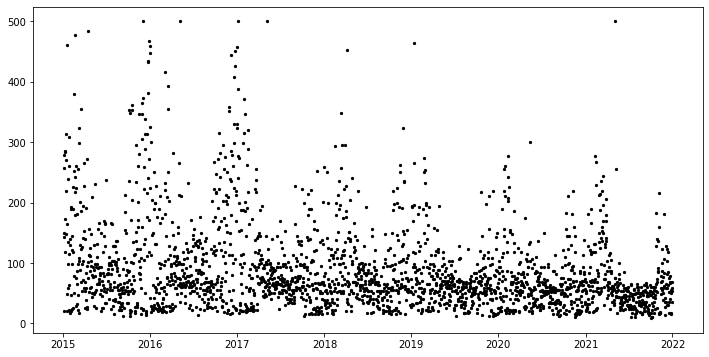

In [92]:
y = df_tgt_ct.y
n_periods = len(y_val)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = y_val.index

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
fig = plt.figure(figsize=(12,6))
plt.scatter(y.index,y,color = 'black',label='real',s=5)
plt.plot(pd.Series(model.predict_in_sample(),index=y_train.index),color='orange',label='prediction in sample',linewidth=1,alpha=0.6)
plt.plot(fc_series, color='orange',label='forecast',alpha=1,linewidth=1.2,marker='o',markersize=0.5)
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.vlines(y_train.index[len(y_train)-1],0,max(y), colors = "r", linestyles = "dashed",label='train/test split')
plt.xlabel('Date (day)')
plt.ylabel(target)
plt.legend()
plt.title("Forecast of ARIMA daily")
plt.savefig('../time_series/pic/day/arima_daily.png',facecolor='w')

In [89]:
from tqdm import tqdm
y_pred = []
for idx in tqdm(y_val.index):
    y_pred.append(model.fit_predict(y[:idx],n_periods=1, return_conf_int=False)[0])

 97%|█████████▋| 483/499 [07:41<00:21,  1.35s/it]

<Figure size 432x288 with 0 Axes>

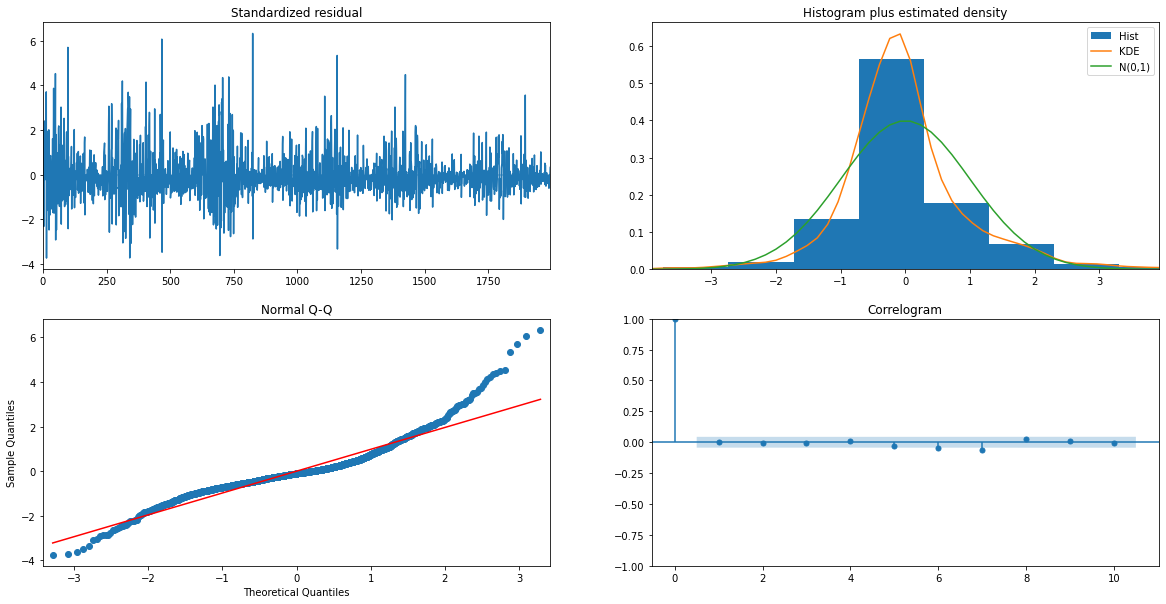

In [87]:
%matplotlib inline
plt.figure(facecolor='w')
model.plot_diagnostics(figsize=(20,10))
plt.savefig('../time_series/pic/day/arima_error.png')
plt.show()

In [106]:
from metrics import calc_metric
calc_metric(y_val.y,y_pred,'arima_daily').to_csv('../result/arima_daily.csv')